In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import torchvision
import os
import cv2

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        # nn.init.xavier_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        # nn.init.xavier_normal_(self.conv2.weight)
        self.drop1 = nn.Dropout2d(0.3)
        self.drop2 = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(800, 64)
        # nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(64, 302)
        # nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, x):
        x = torch.div(x,255)
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)) , 2)
        x= self.drop1(x)
        x= self.flatten(x)
        x= self.fc1(x)
        x= self.drop2(x)
        x= self.fc2(x)
        # return F.log_softmax(x, dim=1)
        return torch.argmax(x)

In [3]:
network = Net() # model initialization
learning_rate = 0.1
momentum = 0.9
# load saved model 
path = "/local/mnt3/workspace3/Kishore/Battlemodes_MNIST/chkpoints_noscaling_noargmax/"
network.load_state_dict(torch.load(path + 'Nov10_accTrainSynthetic_0.9949_accTrain_0.9980_accTest_0.9994_iter_222_model.pt'))
network.eval() # use for evaluation to remove dropout layers , ....

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (drop1): Dropout2d(p=0.3, inplace=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=302, bias=True)
)

In [4]:
# load Test data---------------------------------------------------------------
TestRoot = '/local/mnt3/workspace3/Kishore/Battlemodes_MNIST/data/Test_data_labelled/'
SaveRoot = '/local/mnt3/workspace3/Kishore/Battlemodes_MNIST/data/Test_evaluations/'
Testfilelist= os.listdir(TestRoot)
tnum = len(Testfilelist)

error=0
ii = -1
orignum = np.zeros(tnum, dtype=int)
prednum = np.zeros(tnum, dtype=int)
fporignum = np.zeros(tnum, dtype=int)
fpprednum = np.zeros(tnum, dtype=int)
test_images= np.zeros([len(Testfilelist),14,24])
fptest_images= np.zeros([len(Testfilelist),14,24])
for imgindex in range(len(Testfilelist)):         
    target = Testfilelist[imgindex][0:3]
    imgcrop_org  = cv2.imread(TestRoot+Testfilelist[imgindex])    
    imgcrop = np.float32(cv2.imread(TestRoot+Testfilelist[imgindex],0))
    imgcrop1 = imgcrop
    test_images[imgindex,:,:] = imgcrop
    # imgcrop = imgcrop[:,:,2]
    # imgcrop= imgcrop/ np.max(imgcrop)
    
    #imgcrop = cv2.resize(imgcrop, size, interpolation = cv2.INTER_AREA)
    imgcrop= imgcrop.reshape([1,1,14,24])
     
    # inference ------
    input_torch = torch.from_numpy(imgcrop)
    test_pred = network(input_torch)
    # test_pred_class_label= torch.argmax(test_pred, dim=1).item()
    test_pred_class_label=test_pred.item()
    prefix_zero='000'
    prefix = prefix_zero[0:3-len(str(test_pred_class_label))] + str(test_pred_class_label) +'_'
    savename =SaveRoot+prefix+ Testfilelist[imgindex]
    cv2.imwrite(savename, imgcrop_org)
    orignum[imgindex] = target
    prednum[imgindex] = test_pred_class_label
    print( f'target :   { target} , prediction {test_pred_class_label} ')
    if int(target)!= int(test_pred_class_label):
        error +=1
        ii += 1
        fporignum[ii] = target
        fpprednum[ii] = test_pred_class_label
        fptest_images[ii,:,:] = imgcrop1
        
accuracy = 1- (error/len(Testfilelist))
print(f'Number of images: {tnum}')
print(f'False predictions: {error}')
print(f'Accuracy: {accuracy*100:.4f}'+'%')

fporignum = fporignum[0:error]
fpprednum = fpprednum[0:error]
fptest_images = fptest_images[0:error,:,:]

target :   010 , prediction 10 
target :   008 , prediction 8 
target :   023 , prediction 23 
target :   009 , prediction 9 
target :   009 , prediction 9 
target :   028 , prediction 28 
target :   000 , prediction 0 
target :   000 , prediction 0 
target :   010 , prediction 10 
target :   000 , prediction 0 
target :   008 , prediction 8 
target :   013 , prediction 13 
target :   005 , prediction 5 
target :   003 , prediction 3 
target :   018 , prediction 18 
target :   003 , prediction 3 
target :   008 , prediction 8 
target :   014 , prediction 14 
target :   008 , prediction 8 
target :   009 , prediction 9 
target :   012 , prediction 12 
target :   002 , prediction 2 
target :   010 , prediction 10 
target :   013 , prediction 13 
target :   010 , prediction 10 
target :   025 , prediction 25 
target :   000 , prediction 0 
target :   008 , prediction 8 
target :   003 , prediction 3 
target :   003 , prediction 3 
target :   007 , prediction 7 
target :   008 , prediction

<Figure size 1200x500 with 0 Axes>

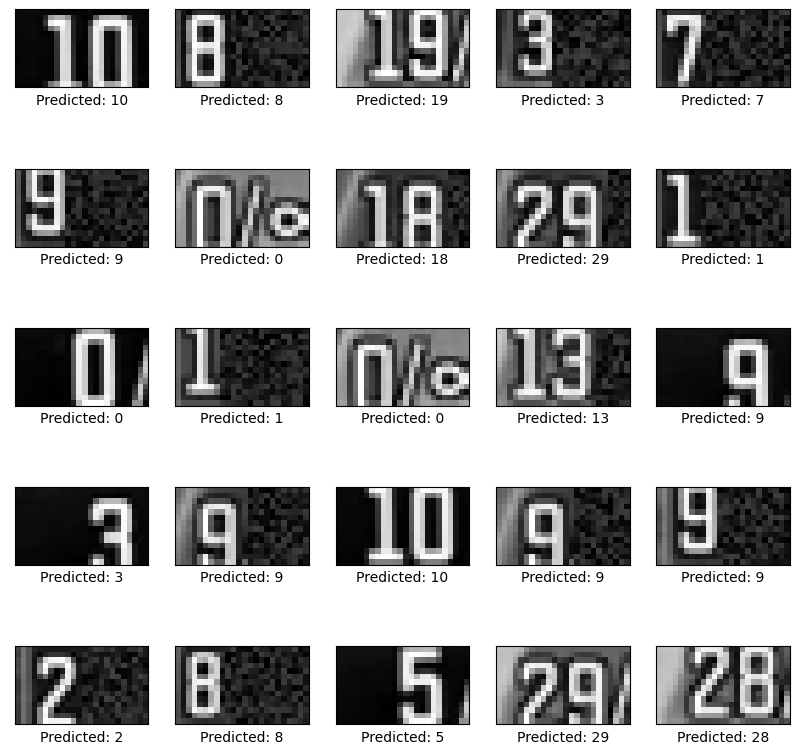

In [5]:
#Test images with predictions
import glob
import random
import math
fig = plt.figure(figsize=(12,5))
def plot_predicted(images, labels, sample_count=25):
    numbs = random.sample(range(1,170), sample_count)
    #create a square box for each image
    grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
    grid_count = min(grid_count, len(images), len(labels))

    plt.figure(figsize=(2*grid_count, 2*grid_count))
    for index, value in enumerate(numbs):
        plt.subplot(grid_count, grid_count, index+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(images[value]), cmap = plt.cm.gray)
    
        label = f'Predicted: {labels[value]}'
        plt.xlabel(label)
        
    plt.show()
    
plot_predicted(test_images,prednum, sample_count = 25)

#### False predictions

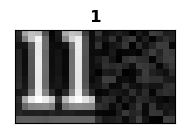

In [6]:
#plot the some of the images along with the label
num = len(fpprednum)
fig = plt.figure(figsize=(12,4))
for indx in range(num):
    #divide current figure into an mxn grid and create axes in the position
    #with 2 rows and 5 columns
    ax = fig.add_subplot(2, int(10/2), indx+1, xticks=[], yticks=[])
    #imshow is display data as an image
    #squeeze means remove single-dimensional entries from the shape of array(ex: (28,28,1) = (28,28))
    ax.imshow(np.squeeze(fptest_images[indx]), cmap='gray')
    #place the label on each image
    ax.set_title(fpprednum[indx].item(),fontweight="bold",size=12)